# Pareto Conditioned networks

Using the modified dam environment (less variance in the inflow), test PCN. This modifications is necessary because PCN expects deterministic transitions.

Also a modification to the original PCN code in morl-baselines is necessary in order to support the continuous actions of the environment:
- continuous_actions is a parameter given to the algorithm
- During training, actions are no longer sampled from a categorical distribution as in the [original paper](https://www.ifaamas.org/Proceedings/aamas2022/pdfs/p1110.pdf). This might hinder exploration...
- The logsoftmax function of the original model is no longer used, instead its output is a single value corresponding to an action
- The loss used in the model is now MSE instead of CE (regression loss vs classification)

In [1]:
from gymnasium.core import Env
import mo_gymnasium as mo_gym
import gymnasium as gym
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from morl_baselines.multi_policy.pcn.pcn import PCN
from gymnasium.utils import EzPickle

"""
Helper function to plot pf
"""
def plot_pf(file):
    columns = ["objective_1", "objective_2"]
    df = pd.read_csv(file, usecols=columns)

    plt.plot(df.objective_1, df.objective_2, 'o')
    plt.xlabel('Cost due to excess water level wrt flooding threshold upstream')
    plt.ylabel('Deficit in water supply wrt demand')
    plt.show()

#
"""
Scale rewards down to improve PCN's performance
"""
class ScaleReward(gym.RewardWrapper, EzPickle):
    def __init__(self, env: Env):
        super().__init__(env)
        EzPickle.__init__(env)

    def reward(self, reward):
        reward = (reward / 100.0)
        return reward

## First attempt

- Dam inflow: mean = 40.0 and stdev = 1.0 
- Actions capped between [0.0;250.0] (motivation in gpi-ls notebook)
- Scaling factor for desired horizon/return = [0.1, 0.1]
- Hypervolume ref point = [-100, -1000]
- Random noise: X~N(0;25.0) Noise is added directly to action.
- Gamma = 1

Also, returns are scaled down with factor 100 because PCN is sensitive to the range of returns. This also removes the need to average the returns over the 100 timesteps in order to compare with MOFQI and GPI.

Decay noise every 100000 steps

In [ ]:
env = mo_gym.make('water-reservoir-v0', normalized_action=False, nO=2, penalize=False, time_limit=100)

env = ScaleReward(env)

PCNAgent = PCN(env, np.array((0.1, 0.1, 0.1), dtype=np.float32), continuous_actions=True, experiment_name='PCN_lowvariance', noise=5)

max_return = np.zeros(2)

PCNAgent.train(2000000, env, np.array((-100.0,-1000), dtype=np.float32), num_step_episodes=100, max_return=max_return, num_eval_episodes_for_front=5, n_points=11)

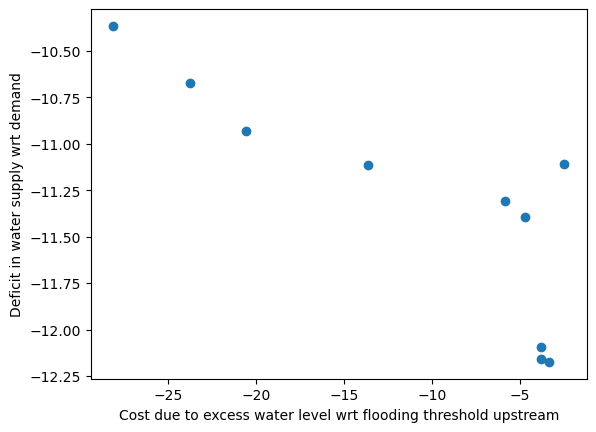

In [4]:
plot_pf('./noise5.csv')

When looking at the returns, there is significant improvement during training. However, the returns are also significantly higher than those of the solution set in the GPI experiments (when scaled back up by factor 100). Learning becomes unstable after around 7000000 steps. => Decay noise (probably)

## Attempt 2

Added noise decay of 0.99 every 100000 steps

# TODO:
- Experiment with scaling factor for desired return
- Experiment with noise: add as parameter, implement decay
- Try to scale the action as in the TD3 policy net (tanh + noise, scale output up)

In [ ]:
env = mo_gym.make('water-reservoir-v0', normalized_action=False, nO=2, penalize=True, time_limit=100)

env = ScaleReward(env)

PCNAgent = PCN(env, np.array((0.01, 0.01, 0.1), dtype=np.float32), continuous_actions=True, noise=5.0)

max_return = np.zeros(2)

PCNAgent.train(10000000, env, np.array((-100.0,-100.0), dtype=np.float32), num_step_episodes=100,max_return=max_return)

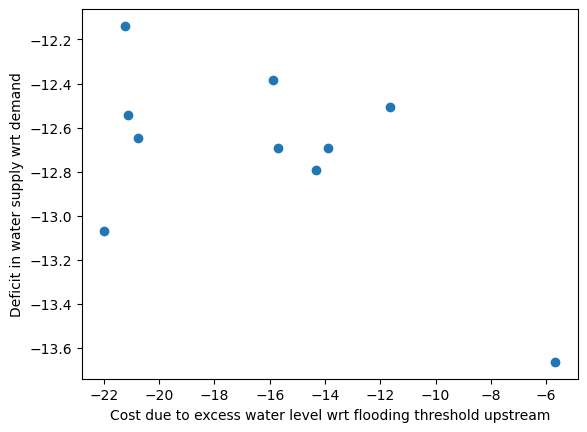

In [3]:
plot_pf('./noise5_decay_smallScaling.csv')

Returns are slightly worse than when using no decay and higher scaling factor.

Try to increase the scaling factor.

Returns in obj 1 are significantly worse. Stick to scaling factor of 0.1 for now.

## Original environment

Test PCN on the original environment (inflow stdev 10.0) and compare its buffer contents with the evaluated returns

### Non-normalized actions, penalty

In [ ]:
env = mo_gym.make('water-reservoir-v0', normalized_action=False, nO=2, penalize=True, time_limit=100)
env = ScaleReward(env)

PCNAgent = PCN(env, np.array((0.1, 0.1, 0.1), dtype=np.float32), continuous_actions=True, noise=20.0, experiment_name='PCN_noise20_pen')
max_return = np.zeros(2)

buffered_returns = PCNAgent.train(10000000, env, np.array((-10.0,-13.0), dtype=np.float32), num_step_episodes=100, max_return=max_return, return_n_largest=True, num_eval_episodes_for_front=100, n_points=11)

buffered_returns = np.array(buffered_returns).transpose()
df = pd.DataFrame({'objective_1': buffered_returns[0], 'objective_2': buffered_returns[1]})
df.to_csv('./buffer_pen.csv', index=False)

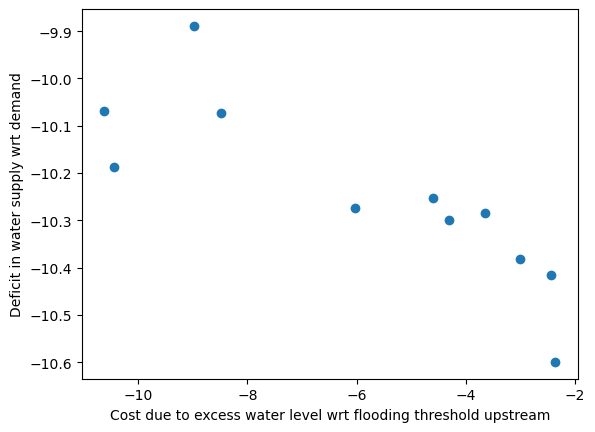

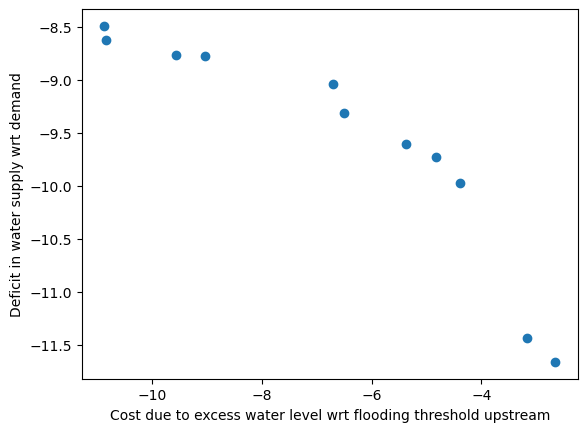

In [11]:
plot_pf('./noise20_pen.csv')
plot_pf('./buffer_pen.csv')

The returns from the buffer do not correspond those observed during evaluation. This is thanks to the high stochasticity of the environment in combination with the use of penalty. It is clear now that by using a penalty, the returns in objective 1 are bad.

## No penalty

Do not penalize the policy. Train for less timesteps, as returns do not improve significantly with more training. Average evaluation returns over 50 timesteps

In [ ]:
env = mo_gym.make('water-reservoir-v0', normalized_action=False, nO=2, penalize=False, time_limit=100)
env = ScaleReward(env)

PCNAgent = PCN(env, np.array((0.1, 0.1, 0.1), dtype=np.float32), continuous_actions=True, noise=20.0, experiment_name='PCN_noise20')
max_return = np.zeros(2)

buffered_returns = PCNAgent.train(5000000, env, np.array((-100.0,-100.0), dtype=np.float32), num_step_episodes=100, max_return=max_return, return_n_largest=True, num_eval_episodes_for_front=100, n_points=11)

buffered_returns = np.array(buffered_returns).transpose()
df = pd.DataFrame({'objective_1': buffered_returns[0], 'objective_2': buffered_returns[1]})
df.to_csv('./buffer.csv', index=False)

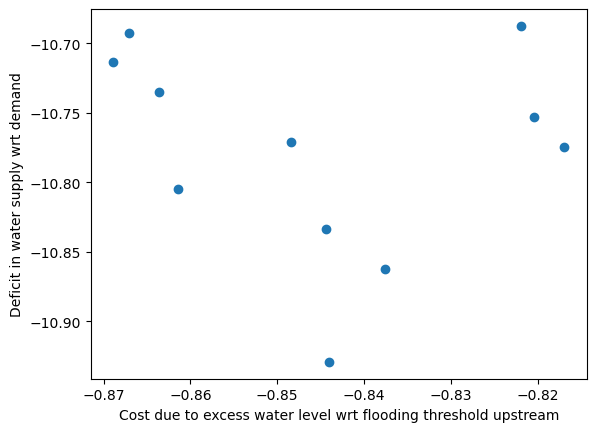

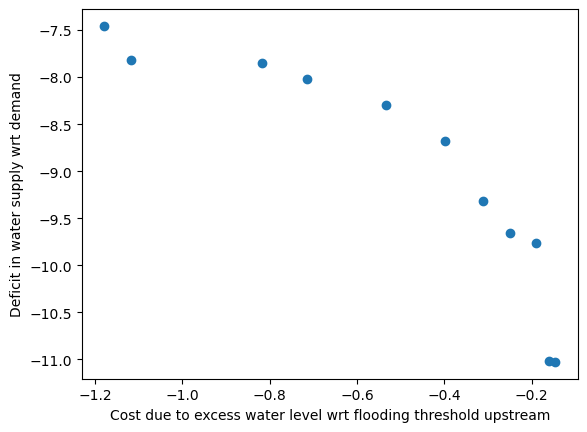

In [4]:
plot_pf('./noise20.csv')
plot_pf('./buffer.csv')

Tradeoffs are not clearly visible and the evaluated returns are worse than those in buffer. This is because the returns in the buffer are those that were 'lucky'

### Normalized actions

Results should correspond to previous ones, but algo might perform better due to smaller action space.

In [ ]:
env = mo_gym.make('water-reservoir-v0', normalized_action=True, nO=2, penalize=False, time_limit=100)
env = ScaleReward(env)

PCNAgent = PCN(env, np.array((0.1, 0.1, 0.1), dtype=np.float32), continuous_actions=True, noise=0.3, experiment_name='PCN_noise05_norm')
max_return = np.zeros(2)

buffered_returns = PCNAgent.train(5000000, env, np.array((-100.0,-100.0), dtype=np.float32), num_step_episodes=100, max_return=max_return, return_n_largest=True, num_eval_episodes_for_front=100, n_points=11)

buffered_returns = np.array(buffered_returns).transpose()
df = pd.DataFrame({'objective_1': buffered_returns[0], 'objective_2': buffered_returns[1]})
df.to_csv('./buffer_norm.csv', index=False)

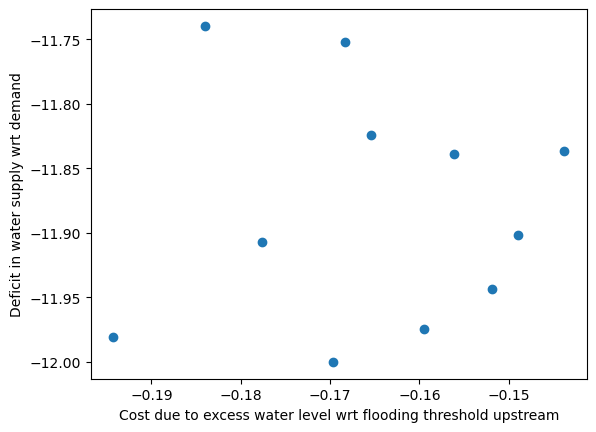

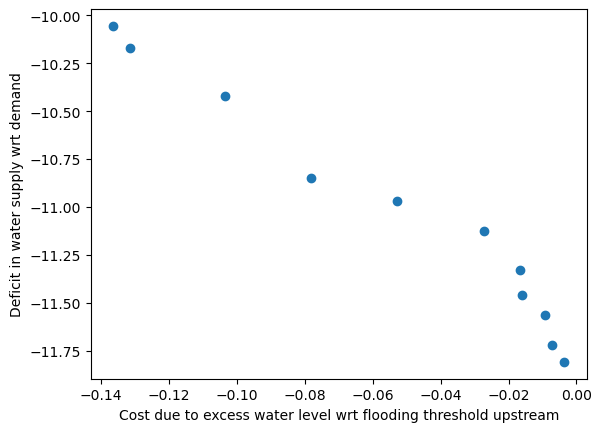

In [4]:
plot_pf('./noise03_norm.csv')
plot_pf('./buffer_norm.csv')